In [1]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Convolution2D, MaxPooling2D, Flatten, Lambda, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [6]:
# load csv
def load_and_split_data(data_dir, test_size=0.2, file_names=None, load_three=False, steer_left=0.08, steer_right=0.04):
    files = []
    if file_names == None:  # if not assined, then using all the training data
        files = glob(data_dir + "*/*.csv")
    else:
        files = [(data_dir + f + "/driving_log.csv") for f in file_names]
    samples = []
    for f in files:
        with open(f) as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                steer_center = float(line[3])
                if load_three:
                    samples.append(["." + line[0][line[0].find("/data/"):], steer_center])
                    samples.append(["." + line[1][line[1].find("/data/"):], steer_center + steer_left])
                    samples.append(["." + line[2][line[2].find("/data/"):], steer_center - steer_right])
                else:
                    samples.append([["." + line[0][line[0].find("/data/"):]], steer_center])
                    
    train_samples, validation_samples = train_test_split(samples, test_size=test_size)
    return train_samples, validation_samples

# the data generator
def generator(samples, batch_size=32, with_shuffle=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if with_shuffle:
            shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for sample in batch_samples:
                images.append(cv2.imread(sample[0]))
                angles.append(sample[1])
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train) if with_shuffle else (X_train, y_train)

In [7]:
train_samples, validtion_samples = load_and_split_data("./data/", file_names=["0314", "0319-2"], load_three=True)
len(train_samples), len(validtion_samples)

(10596, 2649)

In [8]:
train_samples[:10]

[['./data/0314/IMG/left_2017_03_14_22_19_40_115.jpg', 0.08],
 ['./data/0314/IMG/center_2017_03_14_22_20_21_142.jpg', 0.0],
 ['./data/0314/IMG/left_2017_03_14_22_19_39_634.jpg', 0.08],
 ['./data/0319-2/IMG/center_2017_03_18_17_06_36_946.jpg', 1.0],
 ['./data/0319-2/IMG/left_2017_03_18_17_05_10_886.jpg', 0.08],
 ['./data/0319-2/IMG/left_2017_03_18_17_04_20_184.jpg', 0.08],
 ['./data/0319-2/IMG/center_2017_03_18_17_04_07_275.jpg', 0.9045729],
 ['./data/0319-2/IMG/left_2017_03_18_17_05_13_131.jpg', -0.12103389999999999],
 ['./data/0314/IMG/left_2017_03_14_22_22_11_146.jpg', -0.1887818],
 ['./data/0314/IMG/left_2017_03_14_22_22_14_496.jpg', 0.11133005]]

In [9]:
# test the generator
count = 0
for t, v in generator(train_samples, batch_size=10, with_shuffle=True):
    count += 1
    if count == 2:
        break
    print(count, len(t), t[0].shape)

1 10 (160, 320, 3)


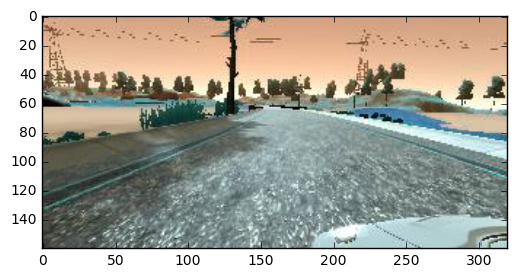

In [19]:
plt.imshow(t[0])

In [20]:
[v[i] for i in range(3)]

[-0.2751189, 0.080000000000000002, 0.0]

In [ ]:
# the LeNet5 architecture
def Lenet():
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    model.add(Convolution2D(6, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(16, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation("relu"))

    model.add(Dense(84))
    model.add(Activation("relu"))

    model.add(Dense(1))
    # model.add(Activation("softmax"))


In [10]:
# the Nivida Paper 
# (http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) 
# 
def Nivdia():
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    
    model.add(Convolution2D(3, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(24, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(36, 3, 3, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(16, 3, 3, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation("relu"))

    model.add(Dense(84))
    model.add(Activation("relu"))

    model.add(Dense(1))
    # model.add(Activation("softmax"))
    return model


In [21]:
model = Nivdia()

train_samples, validation_samples = load_and_split_data('./data/', 
                                                        file_names=["0314", "0319-2"], 
                                                        load_three=True,
                                                        steer_left=0.04,
                                                        steer_right=0.04
                                                       )

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(loss='mse', optimizer="adam")

model.fit_generator(train_generator, samples_per_epoch= \
                len(train_samples), validation_data=validation_generator, 
                nb_val_samples=len(validation_samples), nb_epoch=3)

model.save("model-lenet-0319.h5")


Epoch 1/3
10596/10596 [==============================] - 287s - loss: 0.1660 - val_loss: 0.1582
Epoch 2/3
10596/10596 [==============================] - 287s - loss: 0.1563 - val_loss: 0.1530
Epoch 3/3
10596/10596 [==============================] - 290s - loss: 0.1512 - val_loss: 0.1531


In [ ]:
# samples = []
# data_dir = './data/track1/20170304/'
# with open(data_dir + 'driving_log.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         samples.append(line)

# train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
#                 name = data_dir + './IMG/'+batch_sample[0].split('/')[-1]
#                 center_image = cv2.imread(name)
#                 center_angle = float(batch_sample[3])
#                 images.append(center_image)
#                 angles.append(center_angle)

#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
# validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
for X_train in next(train_generator):
    len(X_train)